The purpose of this work is to run the entire pipeline through the official test file. Now all the test data is stored in the drive, but first you must download the official csv and json files to align the subtitles.

In [40]:
#@title 1. Setup and Environment
#@markdown Mounts Drive, installs all necessary libraries, and handles all imports for the entire process.
from google.colab import drive
drive.mount('/content/drive')

# Install necessary libraries
!pip install tensorflow opencv-python mediapipe scikit-learn pandas moviepy

# Import all required modules
import os
import numpy as np
import pandas as pd
import mediapipe as mp
from moviepy.editor import VideoFileClip

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

print("✅ Setup Complete")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Setup Complete


In [42]:
#@title 2. Landmark Extraction & In-Memory Processing (Corrected)
#@markdown This version fixes the errors by processing the full video clips directly and removing the unnecessary `writeable` flag.

# --- Define Constants ---
DRIVE_ROOT = '/content/drive/MyDrive'
RAW_VIDEOS_PATH = os.path.join(DRIVE_ROOT, 'raw_videos')
CSV_PATH = '/content/how2sign_test.csv'
SEQUENCE_LENGTH = 30 # Number of frames per sequence
NUM_VIDEOS_TO_PROCESS = 10 # Constraint to process only 10 videos

# --- Initialize MediaPipe ---
mp_holistic = mp.solutions.holistic

def extract_landmarks_from_clip(video_clip):
    """
    Processes a moviepy video clip object in memory and extracts landmarks.
    """
    frame_features = []
    holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)

    for frame in video_clip.iter_frames():
        image = frame
        image.flags.writeable = False
        results = holistic.process(image)

        # CHANGE 1: The line 'image.flags.writeable = True' has been removed to prevent the error.

        # Extract and flatten landmarks
        pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
        face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
        lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
        rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

        frame_vector = np.concatenate([pose, face, lh, rh])
        frame_features.append(frame_vector)

    holistic.close()
    return frame_features

# --- Main Processing Loop ---
print("🚀 Starting Data Processing Workflow...")
try:
    df = pd.read_csv(CSV_PATH, sep='\t')
    print(f"✅ CSV loaded. Processing the first {NUM_VIDEOS_TO_PROCESS} videos.")

    X, y = [], []
    # Use pd.factorize to get unique labels and their integer mapping at the same time
    labels, unique_labels = pd.factorize(df['SENTENCE'])
    label_map = {i: label for i, label in enumerate(unique_labels)}
    print(f"Label map created for {len(label_map)} classes.")


    for index, row in df.head(NUM_VIDEOS_TO_PROCESS).iterrows():
        video_filename = row['SENTENCE_NAME']
        label_index = labels[index] # Get the integer label for the current row
        source_video_path = os.path.join(RAW_VIDEOS_PATH, f"{video_filename}.mp4")

        if not os.path.exists(source_video_path):
            print(f"⚠️ Warning: Source video not found at '{source_video_path}'. Skipping.")
            continue

        try:
            # CHANGE 2: Load the video and process it directly, without using subclip.
            with VideoFileClip(source_video_path) as video:
                features = extract_landmarks_from_clip(video)
                if features:
                    X.append(features)
                    y.append(label_index)
                    print(f"✅ Processed '{video_filename}' successfully.")
                else:
                    print(f"⚠️ Skipped '{video_filename}' (0 frames extracted).")

        except Exception as e:
            print(f"❌ Error processing video '{video_filename}': {e}")

    # --- Final Data Preparation ---
    if not X:
        raise ValueError("No data was successfully processed. Cannot proceed.")

    X_padded = pad_sequences(X, maxlen=SEQUENCE_LENGTH, padding='post', truncating='post', dtype='float32')
    y_categorical = to_categorical(np.array(y), num_classes=len(label_map))
    X_train, X_test, y_train, y_test = train_test_split(X_padded, y_categorical, test_size=0.20, random_state=42) # Removed stratify as it may fail with very few samples per class

    print("\n✨ Data processing complete.")
    print(f"Shape of training data (X_train): {X_train.shape}")
    print(f"Shape of training labels (y_train): {y_train.shape}")

except Exception as e:
    print(f"\nAn overall error occurred: {e}")

🚀 Starting Data Processing Workflow...
✅ CSV loaded. Processing the first 10 videos.
Label map created for 1938 classes.
✅ Processed '-fZc293MpJk_0-1-rgb_front' successfully.
✅ Processed '-fZc293MpJk_2-1-rgb_front' successfully.
✅ Processed '-fZc293MpJk_3-1-rgb_front' successfully.
✅ Processed '-fZc293MpJk_4-1-rgb_front' successfully.
✅ Processed '-fZc293MpJk_5-1-rgb_front' successfully.
✅ Processed '-fZc293MpJk_6-1-rgb_front' successfully.
✅ Processed '-fZc293MpJk_7-1-rgb_front' successfully.
✅ Processed '-g0iPSnQt6w_0-1-rgb_front' successfully.
✅ Processed '-g0iPSnQt6w_1-1-rgb_front' successfully.
✅ Processed '-g0iPSnQt6w_10-1-rgb_front' successfully.

✨ Data processing complete.
Shape of training data (X_train): (8, 30, 1662)
Shape of training labels (y_train): (8, 1938)


In [43]:
#@title 3. Build and Train the LSTM Model
#@markdown This cell defines the model architecture, compiles it, and runs the training process.

if 'X_train' in locals() and len(X_train) > 0:
    print("\n🧠 Building the LSTM Model...")

    # Get model parameters from the data
    num_features = X_train.shape[2] # Should be 1662
    num_classes = y_train.shape[1]

    model = Sequential()
    model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(SEQUENCE_LENGTH, num_features)))
    model.add(LSTM(128, return_sequences=True, activation='relu'))
    model.add(LSTM(64, return_sequences=False, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.summary()

    print("\n🔥 Starting Model Training...")
    # Note: With very little data, the model will overfit instantly.
    # This is just to verify the pipeline runs end-to-end.
    history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=10)

    print("\n🎉 Training Complete! The full pipeline has run successfully.")
else:
    print("\nSkipping model training because no data was prepared.")

  super().__init__(**kwargs)




🧠 Building the LSTM Model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1938)           │        63,954 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 660,530 (2.52 MB)

 Trainable params: 660,530 (2.52 MB)

 Non-trainable params: 0 (0.00 B)


🔥 Starting Model Training...
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - categorical_accuracy: 0.0000e+00 - loss: 7.5750 - val_categorical_accuracy: 0.0000e+00 - val_loss: 7.5309
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - categorical_accuracy: 0.0000e+00 - loss: 7.5607 - val_categorical_accuracy: 0.0000e+00 - val_loss: 7.2923
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step - categorical_accuracy: 0.0000e+00 - loss: 7.4592 - val_categorical_accuracy: 0.0000e+00 - val_loss: 15.3083
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - categorical_accuracy: 0.0000e+00 - loss: 13.7304 - val_categorical_accuracy: 0.0000e+00 - val_loss: 8.3454
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - categorical_accuracy: 0.0000e+00 - loss: 7.7363 - val_categorical_accuracy: 0.0000e+00 - val_loss: 8.7746
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - categorical_accuracy: 0.0000e+00 - loss: 7.7456 - val_categorical_accuracy: 0.0000e+00 - val_loss: 8.3194
Epoch 7/30
1/1 ━━━━━━━━━━━

✅ Model training history found. Generating evaluation plots...


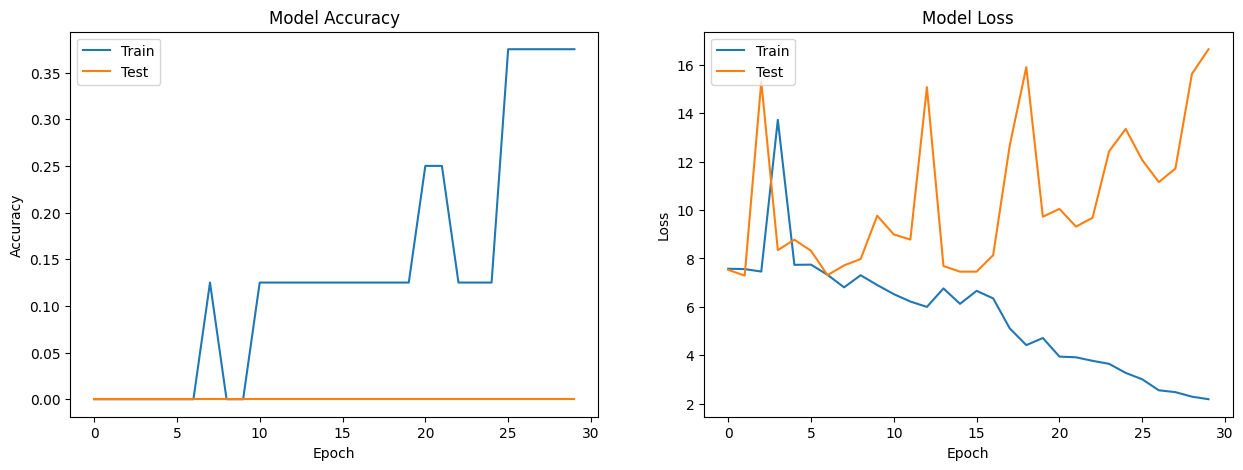


Generating Confusion Matrix...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Test Set Accuracy: 0.00%


  fig.canvas.draw()

  fig.canvas.draw()

  fig.canvas.print_figure(bytes_io, **kw)

  fig.canvas.print_figure(bytes_io, **kw)



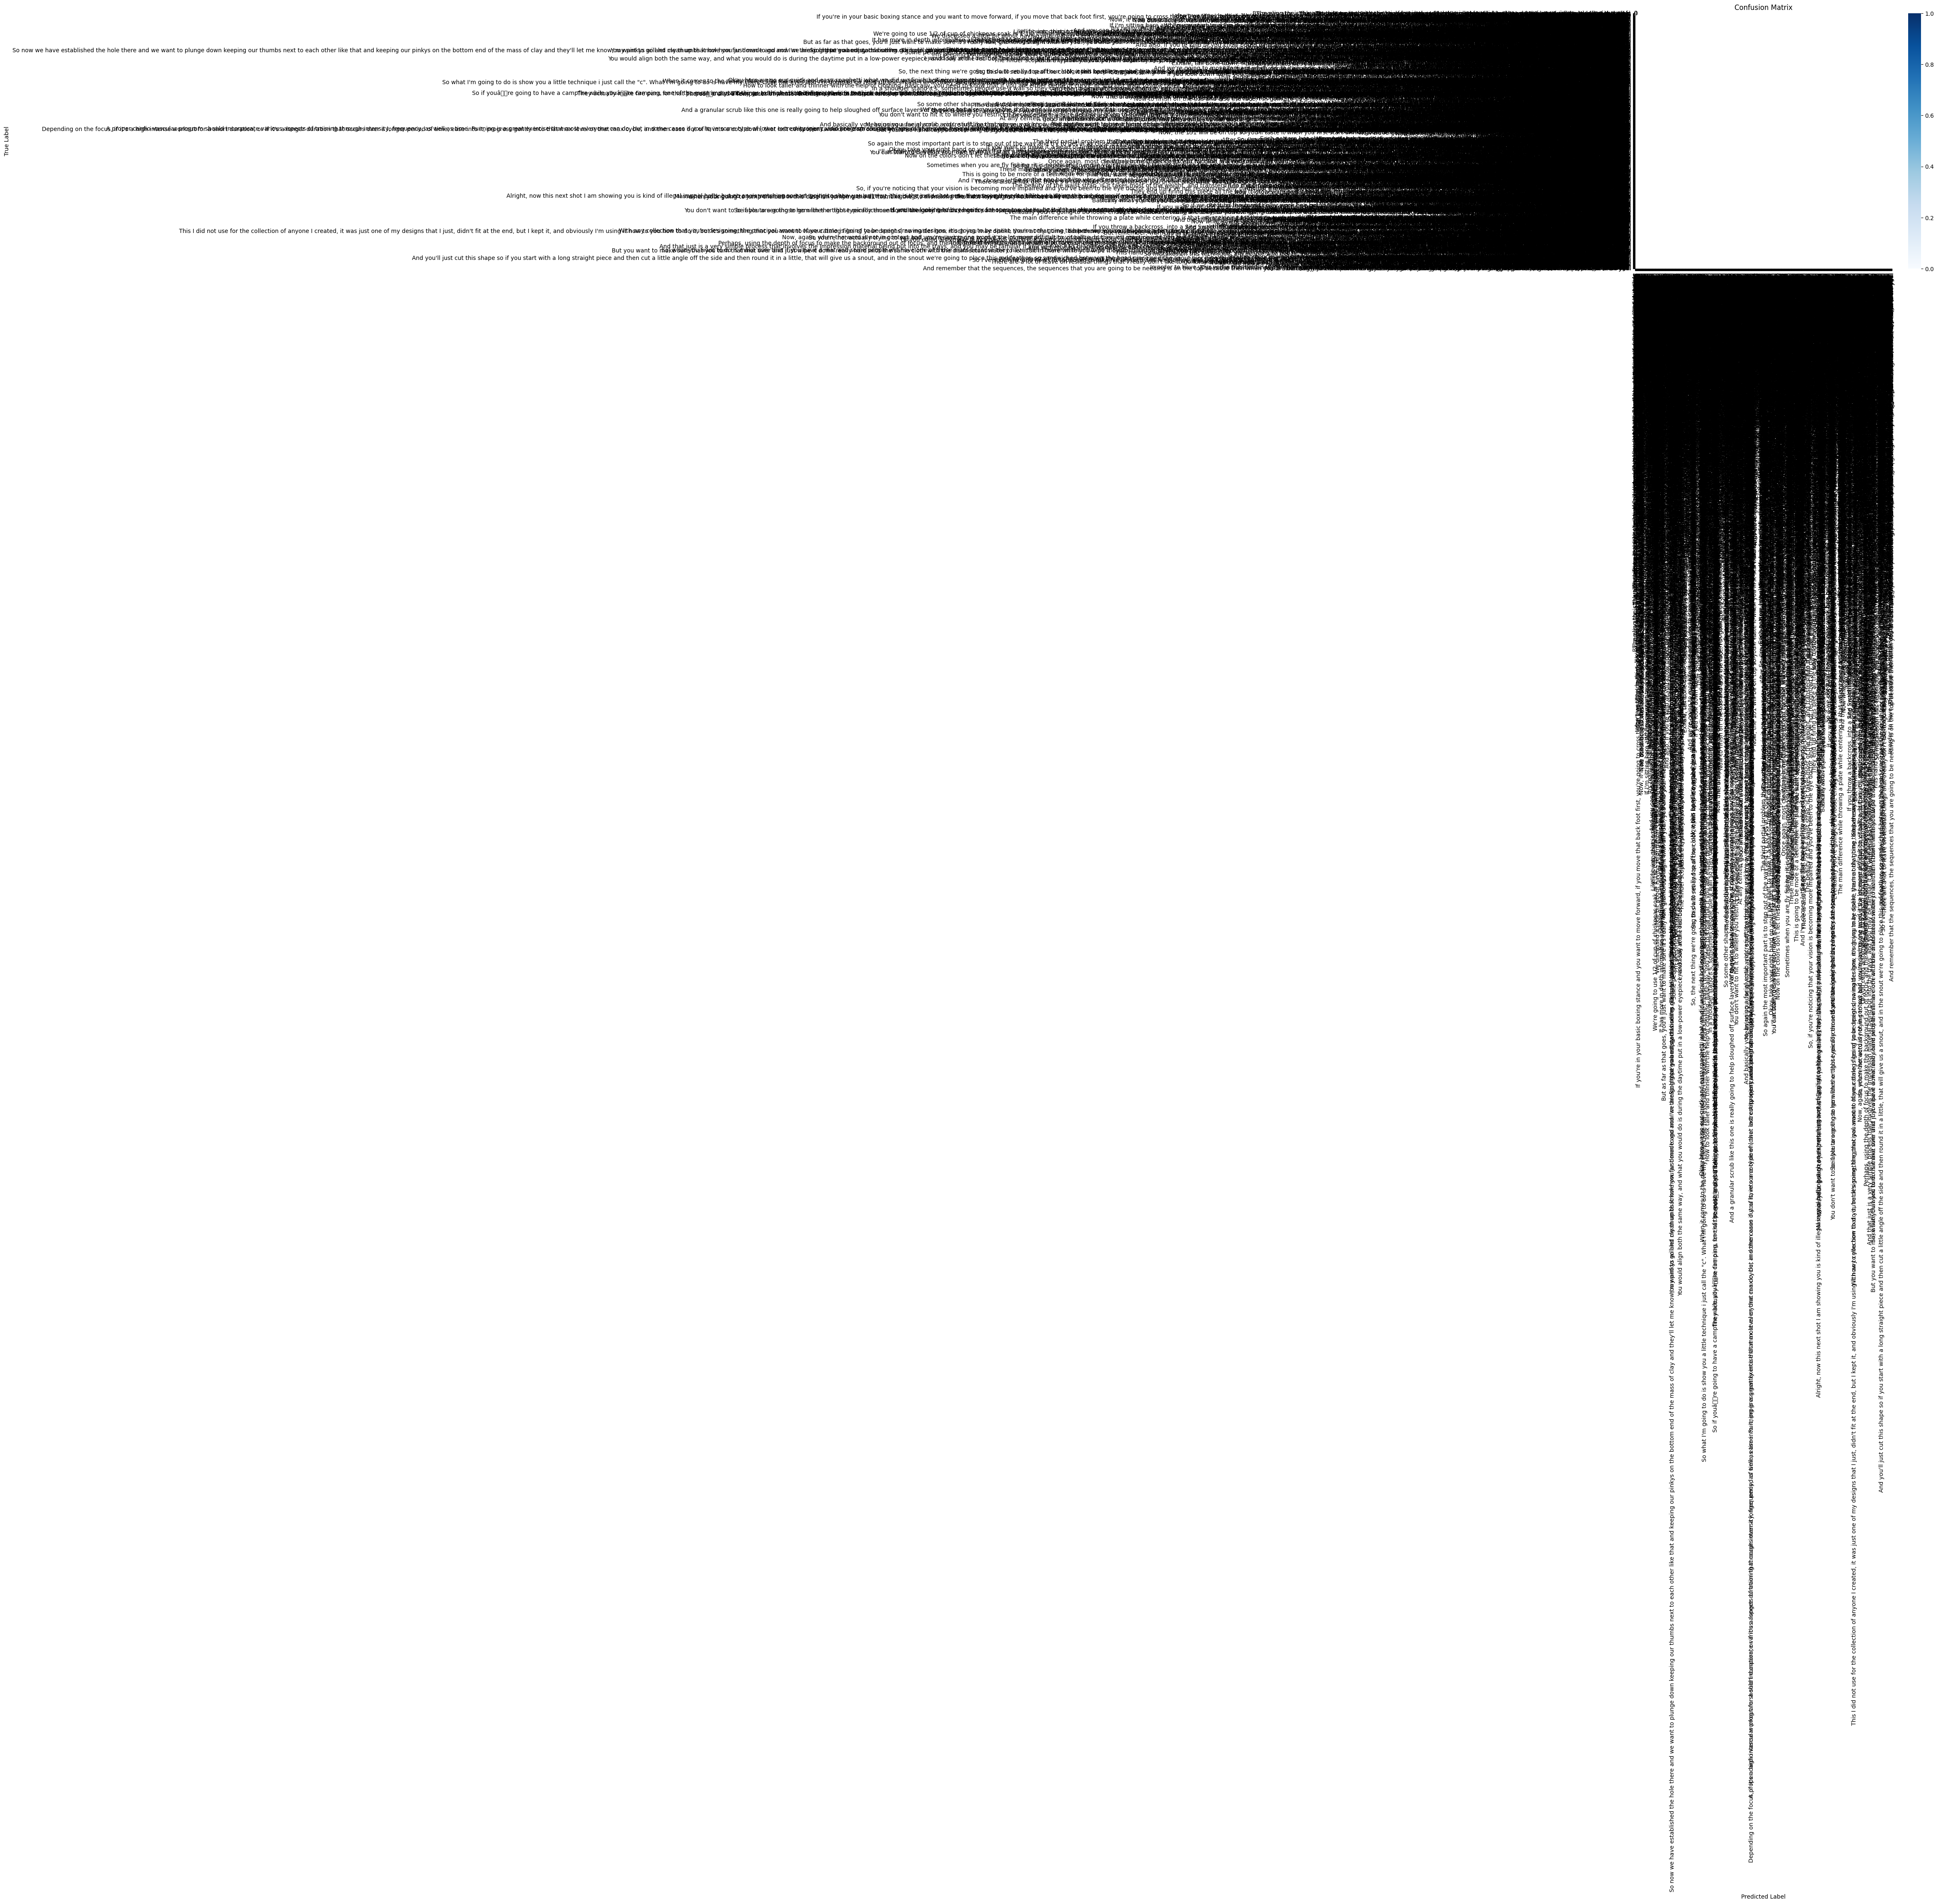


✅ Model saved as 'sign_language_model.keras'


In [44]:
#@title 4. Evaluate Model Performance
#@markdown This cell plots the training history and generates a confusion matrix for the test set.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

if 'history' in locals():
    print("✅ Model training history found. Generating evaluation plots...")

    # --- Plot Accuracy and Loss ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation accuracy values
    ax1.plot(history.history['categorical_accuracy'])
    ax1.plot(history.history['val_categorical_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Test'], loc='upper left')

    plt.show()

    # --- Confusion Matrix ---
    print("\nGenerating Confusion Matrix...")
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    # Convert predictions and true labels from one-hot to integer labels
    y_true_labels = np.argmax(y_test, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Calculate overall accuracy
    test_accuracy = accuracy_score(y_true_labels, y_pred_labels)
    print(f"\nTest Set Accuracy: {test_accuracy * 100:.2f}%")


    # Create the confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    # Get class names from the label map for plotting
    class_names = list(label_map.values())

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # --- Save the final model for the next steps ---
    model.save('sign_language_model.keras')
    print("\n✅ Model saved as 'sign_language_model.keras'")

else:
    print("⚠️ Model history not found. Please run the training cell first.")

In [45]:
#@title 5. Real-Time Implementation (For Local Machine)
#@markdown ⚠️ This code will NOT run in Colab. Copy it to a local .py file.
#@markdown It uses your webcam to perform real-time sign language detection.

import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model
from collections import deque

# --- Load Your Trained Model ---
# Make sure 'sign_language_model.keras' is in the same folder as this script
model = load_model('sign_language_model.keras')

# --- Constants and Settings ---
SEQUENCE_LENGTH = 30 # Should be same as when you trained
# Create a mapping from integer label to sign name
# You'll need to define this based on your 'label_map' from training
# Example:
actions = {
    0: 'Hi!',
    1: 'The aileron is...',
    2: 'By moving the stick...',
    # ... add all your other labels here
}


# --- Landmark Extraction Function (from training) ---
mp_holistic = mp.solutions.holistic

def extract_landmarks(image, holistic_model):
    # Process the frame and get landmarks [cite: 56]
    results = holistic_model.process(image)
    # Flatten the landmark data into a single array
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    # Concatenate all features into a single vector
    return np.concatenate([pose, face, lh, rh])


# --- Real-Time Detection Logic ---
# A deque is a list-like container with fast appends and pops on either end
sequence = deque(maxlen=SEQUENCE_LENGTH)
current_prediction = ''

# Start webcam feed [cite: 94]
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read frame from webcam
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the frame to RGB for MediaPipe
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Extract landmarks for the current frame [cite: 99]
        landmarks = extract_landmarks(image, holistic)
        sequence.append(landmarks)

        # Make prediction only when the sequence is full [cite: 101]
        if len(sequence) == SEQUENCE_LENGTH:
            # Reshape data to match model's expected input shape
            input_data = np.expand_dims(np.array(sequence), axis=0) # (1, 30, 1662)
            prediction = model.predict(input_data, verbose=0)
            # Get the index of the most likely sign [cite: 104]
            pred_index = np.argmax(prediction)

            # Only update the prediction text if confidence is high
            if prediction[0][pred_index] > 0.7: # 70% confidence threshold
                current_prediction = actions.get(pred_index, "Unknown")

        # --- Visualization ---
        # Flip the frame horizontally for a selfie-view display
        frame = cv2.flip(frame, 1)
        # Display the prediction on the frame [cite: 106]
        cv2.putText(frame, current_prediction, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Show the frame to the user [cite: 107]
        cv2.imshow('Sign Language Detection', frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

# Release resources
cap.release()
cv2.destroyAllWindows()

Error: Could not open webcam.


In [2]:
#@title 6. Convert to TensorFlow Lite (for Deployment)
#@markdown This cell converts your saved Keras model into a quantized .tflite model, with the necessary flags to handle LSTM layers correctly.

import tensorflow as tf
import os

# --- Convert the Model ---
try:
    # Load the Keras model we saved earlier
    model = tf.keras.models.load_model('sign_language_model.keras')

    # Create a TFLiteConverter object from the Keras model
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    # --- ADDED FIX ---
    # These two lines solve the TensorList/LSTM conversion error.
    # They tell the converter to use a subset of TensorFlow ops instead of failing.
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS, # Enable TFLite native ops.
        tf.lite.OpsSet.SELECT_TF_OPS    # Enable select TensorFlow ops.
    ]
    converter._experimental_lower_tensor_list_ops = False
    # --- END OF FIX ---


    # Enable quantization optimizations
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Convert the model
    tflite_quant_model = converter.convert()

    # Save the quantized model to a .tflite file
    with open('sign_language_model_quantized.tflite', 'wb') as f:
        f.write(tflite_quant_model)

    print("✅ Model successfully converted to 'sign_language_model_quantized.tflite'")
    # Compare file sizes
    keras_model_size = os.path.getsize('sign_language_model.keras') / (1024)
    tflite_model_size = os.path.getsize('sign_language_model_quantized.tflite') / (1024)
    print(f"\nOriginal Keras Model Size: {keras_model_size:.2f} KB")
    print(f"Quantized TFLite Model Size: {tflite_model_size:.2f} KB")
    print(f"Size reduction: {keras_model_size / tflite_model_size:.2f}x")

except Exception as e:
    print(f"❌ An error occurred during TFLite conversion: {e}")

Saved artifact at '/tmp/tmpfkieob84'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 1662), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1938), dtype=tf.float32, name=None)
Captures:
  136113348177808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136113348175312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136113348174736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136113348174544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136113348173776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136113348173200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136113348174352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136113348172048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136113348171664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136113348175696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1361133481781